Temporal ensembling: [Link](https://arxiv.org/pdf/1610.02242.pdf)

Enhancing NLP performance with SSL: [Link](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1184/lectures/lecture17.pdf)

Stability for transformers (layers reinitializing): [Link](https://www.kaggle.com/code/rhtsingh/on-stability-of-few-sample-transformer-fine-tuning?scriptVersionId=67176591&cellId=29)

Enhancements:
[Link](https://www.kaggle.com/competitions/feedback-prize-english-language-learning/discussion/359511)
# TODO:
- add layer partitioning: [Link](https://assets.amazon.science/d1/f7/0989dfe44244bcfa839bb6c872fb/scipub-1274.pdf)
- use ensembelled model as features extractor
- add cross-validation
- gradual unfreezing
- init model weights from unsupervised
- train model classifier with unlabelled + 0.5 labelled
- finish training with 0.5 labelled
- more data for domain adaptation
- parameters fine-tuning
- layerwise learning rate
- freezing in final model
- train classifier -> choose 30% the most reliable predictions -> add new training data
Final trial:
- multisample dropout
- weighted layer pooling
- orthogonal weights initialization

Note: try gradual unfreezing keeping only top layer unfrozen at first, and then each _n_ steps unfreeze additional layers

Source: https://www.kaggle.com/code/kojimar/fb3-single-pytorch-model-train

In [ ]:
import re
import string
import gc
import os
import shutil
from datetime import datetime
import time
from pathlib import Path
import random
import joblib

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.multioutput import MultiOutputRegressor

import torch
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
from transformers import TextClassificationPipeline, AutoConfig, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup
from transformers import DataCollatorForLanguageModeling, AutoModelForMaskedLM
from transformers import TrainerCallback, EarlyStoppingCallback
from transformers.modeling_outputs import SequenceClassifierOutput

from datasets import Dataset, DatasetDict

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from lightgbm import LGBMRegressor, Booster

# Common Utils

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [ ]:
print(torch.__version__)
sns.set_style('darkgrid')

1.12.1+cu113


In [ ]:
def on_gpu(f):
    def wrapper():
        if torch.cuda.is_available():
            return f()
        else:
            print('cuda unavailable')
    return wrapper

In [ ]:
if torch.cuda.is_available():
    from pynvml import *
    from numba import cuda

@on_gpu
def print_gpu_utilization():
    try:
        nvmlInit()
        handle = nvmlDeviceGetHandleByIndex(0)
        info = nvmlDeviceGetMemoryInfo(handle)
        print(f"GPU memory occupied: {info.used//1024**2} MB.")
    except Exception as e:
        print(e)

@on_gpu
def free_gpu_cache():
    print("Initial GPU Usage")
    print_gpu_utilization()                          

    torch.cuda.empty_cache()

    print("GPU Usage after emptying the cache")
    print_gpu_utilization()
    
def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [ ]:
def to_train_test_splits(X_train, X_test, y_train):
    train_split = pd.concat([X_train, y_train], axis=1)
    test_split = X_test
    return train_split, test_split

def to_train_test_splits_task(X_train, X_test, y_train, label):
    y_train[f'{label}_labels'] = y_train[label].apply(lambda x: REV_LABELS[x])

    train_split = pd.concat([X_train, y_train], axis=1)
    test_split = X_test
    return train_split, test_split

def gaussian(x, T):
    return x * np.exp(- 5 * np.power(1 - T, 2))

def match_with_batchsize(lim, batchsize):
    """
    Function used by modify_datasets below to match return the integer closest to lim
    which is multiple of batchsize, i.e., lim%batchsize=0.

    """

    if lim % batchsize == 0:
        return lim
    else:
        return lim - lim % batchsize

In [ ]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        model.eval()
        return f(model, *args, **kwargs)
    return wrapper

def train(f):
    def wrapper(model, *args, **kwargs):
        model.train()
        return f(model, *args, **kwargs)
    return wrapper

# Metrics and evaluation Utils

In [ ]:
def MCRMSE(actual, predicted):
    squared_diff = (actual - predicted)**2
    sqrt_mean = np.sqrt(np.mean(squared_diff, axis=0))
    return np.mean(sqrt_mean)

def MCRMSE_scores(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:, i]
        y_pred = y_preds[:, i]
        score = mean_squared_error(y_true, y_pred, squared = False)
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores

def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    predictions = np.argmax(logits[0], axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions), 
        'rmse': np.sqrt(mean_squared_error(decode(labels), decode(predictions)))
        }

def decode(predictions):
    return np.array(list(map(lambda x: RAW_LABELS[x], predictions)))

@eval
def perplexity(model, eval_data):
    total_loss = 0
    batch_count = 0
    with torch.no_grad():
        for step, val_input in enumerate(tqdm(eval_data)):
            labels = val_input['labels'].to(device).clone()
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].to(device)
            
            output = model(input_ids=input_id, attention_mask=mask, labels=labels).loss
            total_loss += output.cpu().numpy()
            batch_count+=1
    return np.exp(total_loss.item() / batch_count)

# Preprocessing

In [ ]:
def tokenization(example):
    return tokenizer(example['full_text'], 
                    max_length=512, 
                    padding='max_length', 
                    truncation=True, 
                    add_special_tokens=True,
                    return_tensors='pt')

def tokenize(example):
    return tokenizer(example, 
                    max_length=512, 
                    padding='max_length', 
                    truncation=True, 
                    add_special_tokens=True,
                    return_tensors='pt')
    
def collate(inputs):
    mask_len = int(inputs['attention_mask'].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

# Saving and Loading Utils

In [ ]:
def save_model(fold, model):
    print('Saving model...')
    try:
        Path(f'{BASIC_PATH}/models/{MODEL_NAME}').mkdir(parents=True, exist_ok=True)
        torch.save(model.cpu().state_dict(), f'{BASIC_PATH}/models/{MODEL_NAME}/fold_{fold}')
    except Exception as e:
        print(e)

def save_model_reg(fold, model):
    print('Saving model...')
    try:
        Path(f'{BASIC_PATH}/models/{MODEL_REG}').mkdir(parents=True, exist_ok=True)
        joblib.dump(model, f'{BASIC_PATH}/models/{MODEL_REG}/fold_{fold}.pkl')
    except Exception as e:
        print(e)

def save_model_task(task, model):
    print('Saving model...')
    try:
        Path(f'{BASIC_PATH}/models/ssl/{MODEL_NAME}/{task}').mkdir(parents=True, exist_ok=True)
        torch.save(model.cpu().state_dict(), f'{BASIC_PATH}/models/ssl/{MODEL_NAME}/{task}/final')
    except Exception as e:
        print(e)

def get_tokenizer():
    if os.path.exists(f'{BASIC_PATH}/tokenizers/{MODEL_NAME}'):
        return f'{BASIC_PATH}/tokenizers/{MODEL_NAME}'
    return MODEL_NAME

def save_config(model, config_type):
    print('Saving config:', config_type)
    try:
        config_path = f'{BASIC_PATH}/configs/{MODEL_NAME}'
        model.config.save_pretrained(f'{config_path}/{config_type}')
    except Exception as e:
        print(e)

def get_config_path(config_type):
    config_path = f'{BASIC_PATH}/configs/{MODEL_NAME}/{config_type}'
    if os.path.exists(config_path) and len(os.listdir(config_path)) != 0:
        return config_path
    return MODEL_NAME

def get_checkpoint(task):
    chckpt_path = f'{BASIC_PATH}/models/{MODEL_NAME}/{task}'
    if os.path.exists(f'{chckpt_path}/final'):
        return f'{chckpt_path}/final'
    elif os.path.exists(chckpt_path):
        checkpoints = list(filter(lambda x: x.startswith('checkpoint-'), os.listdir(chckpt_path)))
        checkpoints.sort(reverse=True)
        if len(checkpoints) == 0:
            return MODEL_NAME
        return f'{chckpt_path}/{checkpoints[0]}'
    return MODEL_NAME

def get_model_ssl_path(task):
    model_path = f'{BASIC_PATH}/models/{MODEL_NAME}/ssl/{task}/final'
    if os.path.exists(model_path):
        return model_path
    return MODEL_NAME

def copy_weights(modelSrc, modelDst):
    print('Copying weights from ------->', modelSrc.__class__)
    print('Copying weights to ------->', modelDst.__class__)
    paramsSrc = dict(modelSrc.state_dict())
    paramsDst = dict(modelDst.state_dict())

    dict_paramsDst = paramsDst
    for nameSrc, paramSrc in paramsSrc.items():
        transformedNameSrc = 'base.' + '.'.join(nameSrc.split('.')[1:])
        if transformedNameSrc in dict_paramsDst:
            dict_paramsDst[transformedNameSrc].data.copy_(paramSrc.data)
    modelDst.load_state_dict(dict_paramsDst)
    return modelDst

def get_model(fold=0, retrain=False, pretrained=None, config=None):
    model = FeedbackModel(config)
    if pretrained is not None:
        if 'mlm' in pretrained:
            modelMLM = AutoModelForMaskedLM.from_pretrained(pretrained)
            return copy_weights(modelMLM, model)
        elif 'ssl' in pretrained:
            modelSSL = TemporalEnsembleModel()
            modelSSL.load_state_dict(torch.load(pretrained))
            return copy_weights(modelSSL.base, model)
    if retrain:
        return model
    if is_trained():
        model = FeedbackModel(config)
        model.load_state_dict(torch.load(f'{BASIC_PATH}/models/{MODEL_NAME}/fold_{fold}'))
        return model
    return model

def get_model_reg(fold):
    return joblib.load(f'{BASIC_PATH}/models/{MODEL_REG}/fold_{fold}.pkl')

# Plotting Utils

In [ ]:
def plot_results(fold, results):
    epochs_x = list(range(1, len(results['train_losses']) + 1))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    ax1.plot(epochs_x, results['train_losses'], color='y')
    ax1.plot(epochs_x, results['val_losses'], color='b')
    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')

    ax2.plot(epochs_x, results['val_mcrmse'])
    ax2.set_title('MCRMSE')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('mcrmse')

    plt.title(f'Fold: {fold}')
    
    plt.show()

def plot_scheduler_stats(stats):
    epochs_x = list(range(1, len(stats['lr_history']) + 1))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(epochs_x, stats['lr_history'])
    ax1.set_title('Learning rates')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('learning_rate')

    ax2.plot(epochs_x, stats['weights_history'])
    ax2.set_title('Weights')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('weight')

    plt.title('Scheduler stats')
    
    plt.show()

# Training Utils

In [ ]:
def is_trained(task):
    chckpt_path = f'{BASIC_PATH}/models/{MODEL_NAME}/{task}'
    if os.path.exists(chckpt_path) and os.path.exists(f'{chckpt_path}/trained'):
        return True
    return False

def clean_checkpoints(task, keep=1):
    chckpt_path = f'{BASIC_PATH}/models/{MODEL_NAME}/{task}'
    checkpoints = list(filter(lambda x: x.startswith('checkpoint-'), os.listdir(chckpt_path)))
    checkpoints.sort(reverse=True)
    for chckpt in checkpoints[keep:]:
        print('removing...', f'{BASIC_PATH}/models/{MODEL_NAME}/{task}/{chckpt}')
        shutil.rmtree(f'{BASIC_PATH}/models/{MODEL_NAME}/{task}/{chckpt}', ignore_errors=True)

def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.base.named_parameters() if not any(nd in n for nd in no_decay)],
            'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.base.named_parameters() if any(nd in n for nd in no_decay)],
            'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "base" not in n],
            'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters

def get_optimizer_grouped_parameters(model, layerwise_lr, layerwise_weight_decay, layerwise_lr_decay):
        
        no_decay = ["bias", "LayerNorm.weight"]
        # initialize lr for task specific layer
        optimizer_grouped_parameters = [{"params": [p for n, p in model.named_parameters() if "base" not in n],
                                         "weight_decay": 0.0,
                                         "lr": layerwise_lr,
                                        },]
        # initialize lrs for every layer
        layers = [model.base.embeddings] + list(model.base.encoder.layer)
        layers.reverse()
        lr = layerwise_lr
        for layer in layers:
            optimizer_grouped_parameters += [{"params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
                                              "weight_decay": layerwise_weight_decay,
                                              "lr": lr,
                                             },
                                             {"params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
                                              "weight_decay": 0.0,
                                              "lr": lr,
                                             },]
            lr *= layerwise_lr_decay
        return optimizer_grouped_parameters

def retrain(task):
    model_path = f'{BASIC_PATH}/models/{MODEL_NAME}/{task}'
    print('removing...', model_path)
    shutil.rmtree(model_path, ignore_errors=True)

def freeze(model, layers, dropout=0.5):
    print('Freezing the model...')
    for name, param in model.named_parameters():
        for layer in layers:
            if f'encoder.layer.{layer}.' in name or 'word_embeddings' in name:
                param.requires_grad = False
                print('Freezing layer:', name)
    if dropout is not None:
        for layer in layers:
            model.base.deberta.encoder.layer[layer].output.dropout = torch.nn.Dropout(dropout)
    return model

def unfreeze(model, layer, dropout=0.1):
    print('Unfreezing the model...')
    for name, param in model.named_parameters():
        if layer == -1 and 'word_embeddings' in name:
            param.requires_grad = True
            print('Unfreezing layer:', name)
            
        if f'encoder.layer.{layer}.' in name:
            param.requires_grad = True
            print('Unfreezing layer:', name)
            if dropout is not None:
                model.base.deberta.encoder.layer[layer].output.dropout = torch.nn.Dropout(dropout)
    return model

def re_initializing_layer(model, config, layer_num, init_weight='normal'):
    for module in model.base.encoder.layer[-layer_num:].modules():
        if isinstance(module, torch.nn.Linear):
            if init_weight == 'normal':
                module.weight.data.normal_(mean=0.0, std=config.initializer_range)
            elif init_weight == 'xavier_uniform':
                module.weight.data = torch.nn.init.xavier_uniform_(module.weight.data)
            elif init_weight == 'xavier_normal':
                module.weight.data = torch.nn.init.xavier_normal_(module.weight.data)
            elif init_weight == 'kaiming_uniform':
                module.weight.data = torch.nn.init.kaiming_uniform_(module.weight.data)
            elif init_weight == 'kaiming_normal':
                module.weight.data = torch.nn.init.kaiming_normal_(module.weight.data)
            elif init_weight == 'orthogonal':
                module.weight.data = torch.nn.init.orthogonal_(module.weight.data) 
                
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, torch.nn.Embedding):
            if init_weight == 'normal':
                module.weight.data.normal_(mean=0.0, std=config.initializer_range)
            elif init_weight == 'xavier_uniform':
                module.weight.data = torch.nn.init.xavier_uniform_(module.weight.data)
            elif init_weight == 'xavier_normal':
                module.weight.data = torch.nn.init.xavier_normal_(module.weight.data)
            elif init_weight == 'kaiming_uniform':
                module.weight.data = torch.nn.init.kaiming_uniform_(module.weight.data)
            elif init_weight == 'kaiming_normal':
                module.weight.data = torch.nn.init.kaiming_normal_(module.weight.data)
            elif init_weight == 'orthogonal':
                module.weight.data = torch.nn.init.orthogonal_(module.weight.data)
                
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, torch.nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    return model   
    
class PreplexityCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, model, eval_dataloader, **kwargs):
        print(f"Perplexity: {perplexity(model, eval_dataloader):.3f}")
        print('----------------\n')

# TRAINING

### Domain Adaptation

In [ ]:
def train_masked_lm(model, tokenizer, aug_data, config):
    train_split = aug_data

    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=True, mlm_probability=0.15
    )

    data = DatasetDict({
        'train': Dataset.from_pandas(train_split[['full_text']]),
    })

    print(f'Dataset tokenization')
    data = data.map(tokenization, batched=True)
    data.set_format('pt')

    training_args = TrainingArguments(
        output_dir=f'{BASIC_PATH}/training',
        do_train=True,
        do_eval=False,
        seed=42,
        **config,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=data['train'],
        tokenizer=tokenizer,
    )

    results = trainer.train()
    
    model_path = f'{BASIC_PATH}/models/mlm/{MODEL_NAME}'
    trainer.save_model(model_path)
    return results, model_path

# SSL Training

In [ ]:
def train_task(model, data, config, task):
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    training_args = TrainingArguments(
        output_dir=f'{BASIC_PATH}/models/{MODEL_NAME}/{task}',
        no_cuda=True if device == 'cpu' else False,
        label_names=['labels'],
        do_train=True,
        do_eval=False,
        **config['training_args'],
    )

    # optimizer_parameters = get_optimizer_params(model,
    #     encoder_lr=config['optimizer']['encoder_lr'], 
    #     decoder_lr=config['optimizer']['decoder_lr'],
    #     weight_decay=config['optimizer']['weight_decay']
    # )

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['optimizer']['lr'], 
        eps=config['optimizer']['eps'],
        weight_decay=config['optimizer']['weight_decay']
    )

    num_train_steps = int(len(data['train']) / config['batch_size'] * config['epochs'])
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=config['scheduler'].pop('num_warmup_steps'),
        num_training_steps=num_train_steps,
    )

    callbacks = []
    if 'early_stopping' in config and config['early_stopping']:
        callbacks.append(EarlyStoppingCallback(**config['early_stopping_params']))

    trainer = TrainerWithUWScheduler(
        model=model,
        args=training_args,
        train_dataset=data['train'],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        callbacks=callbacks,
        optimizers=(optimizer, scheduler),
        uw_kwargs=config['scheduler'],
        unfreeze_after=config['unfreeze_after'],
        unfreeze_every=config['unfreeze_every'],
        layer_to_unfreeze=config['layer_to_unfreeze'],
    )

    return trainer

In [ ]:
@eval
def predict_ssl(model, test_data, task):
    model = model.to(device)

    data = Dataset.from_pandas(test_data[['full_text', f'{task}_labels']].rename({f'{task}_labels': 'label', 'full_text': 'text'}, axis=1)).map(tokenization, batched=True)
    data = data.remove_columns(['text', '__index_level_0__'])
    data = data.with_format('torch', device=device) # type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label']
    
    test_dataloader = torch.utils.data.DataLoader(data, batch_size=2 * TRAIN_CONFIG['batch_size'])

    features = []
    with torch.no_grad():
        for test_input in tqdm(test_dataloader):
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].to(device)

            out_features = model(input_id, mask).hidden_states
            features.append(out_features.cpu().numpy())
    return np.concatenate(features)

def predict_features_ssl(test_split, task, pooling='mean'):

    model = TemporalEnsembleModel(pooling=pooling)
    model.load_state_dict(torch.load(f'{BASIC_PATH}/models/{MODEL_NAME}/{task}/final'))
    print(model.pooler)
        
    return predict_ssl(model, test_split, task)

### Supervised Traning

In [ ]:
@train
def train_step(model, criterion, optimizer, scaler, scheduler,  step, train_input, train_labels, config):
    step_loss = 0

    train_labels = train_labels.to(device).float()
    mask = train_input['attention_mask'].to(device)
    input_id = train_input['input_ids'].to(device)

    with torch.cuda.amp.autocast(enabled=True):
        output = model(input_id, mask)
        
        batch_loss = criterion(output, train_labels)
    
    if config['gradient_accumulation_steps'] > 1:
        batch_loss = batch_loss / config['gradient_accumulation_steps']

    step_loss += batch_loss.item()

    if config['fp16']:
        scaler.scale(batch_loss).backward()
    else:
        batch_loss.backward()

    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])

    if (step + 1) % config['gradient_accumulation_steps'] == 0:
        if config['fp16']:
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.step()

        scheduler.step()
        optimizer.zero_grad()

    return step_loss

@eval
def val_step(model, criterion, val_input, val_label):
    step_loss = 0
    step_mcrmse = 0

    val_label = val_label.to(device)
    mask = val_input['attention_mask'].to(device)
    input_id = val_input['input_ids'].to(device)

    output = model(input_id, mask)

    batch_loss = criterion(output, val_label)
    step_loss += batch_loss.item()
    step_mcrmse += MCRMSE(val_label.to('cpu').numpy(), output.to('cpu').numpy())
    return step_loss, step_mcrmse

In [ ]:
def training(model, train_data, val_data, config, do_val=False):
    model.train()

    model = model.to(device)

    scaler =  torch.cuda.amp.GradScaler(enabled=config['apex'])

    if do_val:
        val = FeedbackDataset(val_data)
    train = FeedbackDataset(train_data)

    criterion = torch.nn.SmoothL1Loss(reduction='mean').to(device)
    grouped_optimizer_params = get_optimizer_grouped_parameters(model, 
                                                config['layerwise_lr'], 
                                                config['layerwise_weight_decay'], 
                                                config['layerwise_lr_decay'])

    # optimizer_parameters = get_optimizer_params(model,
    #                                             encoder_lr=config['encoder_lr'], 
    #                                             decoder_lr=config['decoder_lr'],
    #                                             weight_decay=config['weight_decay'])

    optimizer = torch.optim.AdamW(
        grouped_optimizer_params,
        lr=config['lr'], 
        eps=config['eps'],
        weight_decay=config['weight_decay']
    )

    num_train_steps = int(len(train_data) / config['batch_size'] * config['epochs'])
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=config['num_warmup_steps'], 
        num_training_steps=num_train_steps, 
        num_cycles=config['num_cycles'],
    )

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=config['batch_size'], shuffle=True)
    if do_val:
        val_dataloader = torch.utils.data.DataLoader(val, batch_size=config['batch_size'])

    results = {
        'train_losses': [],
        'val_losses': [],
        'val_mcrmse': [],
    }

    layer_to_unfreeze = config['layer_to_unfreeze']
    for epoch_num in range(config['epochs']):
        
        if config['freeze'] and epoch_num >= config['epochs'] * config['unfreeze_after']:
            if layer_to_unfreeze >= -1:
                model = unfreeze(model, layer_to_unfreeze, dropout=None)
            layer_to_unfreeze-=1

        total_loss_train = 0

        for step, (train_input, train_labels) in enumerate(tqdm(train_dataloader)):
            train_input = collate(train_input)
            total_loss_train += train_step(model, criterion, optimizer, scaler, scheduler,  step, train_input, train_labels, config)

        if do_val:
            total_loss_val = 0
            total_mcrmse_val = 0

            with torch.no_grad():

                for step, (val_input, val_label) in enumerate(tqdm(val_dataloader)):
                    step_loss, step_mcrmse = val_step(model, criterion, val_input, val_label)
                    total_loss_val += step_loss
                    total_mcrmse_val += step_mcrmse
        
        # torch.save({
        #     'epoch': {epoch_num + 1},
        #     'model_state_dict': model.to('cpu').state_dict(),
        #     'optimizer_state_dict': optimizer.state_dict(),
        #     'loss': criterion.to('cpu'),
        #     }, f'{BASIC_PATH}/models/{MODEL_NAME}/checkpoints/checkpoint-{str(time.time())}')
        
        train_steps = len(train_data) / config['batch_size']

        if do_val:
            val_steps = len(val_data) / config['batch_size']
        
        results['train_losses'].append(total_loss_train / train_steps)
        if do_val:
            results['val_losses'].append(total_loss_val / val_steps)
            results['val_mcrmse'].append(total_mcrmse_val / val_steps)

        print(f'Epoch: {epoch_num + 1} | Train Loss: {total_loss_train / train_steps: .3f}', end=' ')
        if do_val:
            print(f'| Val Loss: {total_loss_val / val_steps: .3f} | Val MCRMSE: {total_mcrmse_val / val_steps: .3f}')
    return results

In [ ]:
@eval
def evaluate(model, test_data, config):
    model = model.to(device)

    test = FeedbackDataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=config['batch_size'])

    total_score = 0
    with torch.no_grad():
        for test_input, test_labels in tqdm(test_dataloader):
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            total_score += MCRMSE(test_labels.to('cpu').numpy(), output.to('cpu').numpy()) / config['batch_size']
    return total_score / len(test_data)

@eval
def predict(model, test_data, config):
    model = model.to(device)

    test = PredictDataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=config['batch_size'])

    predictions = []
    features = []
    with torch.no_grad():
        for test_input in tqdm(test_dataloader):
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].to(device)

            out_features = model.features(input_id, mask)
            output = model.out(out_features)
            predictions.append(output.cpu().numpy())
            features.append(out_features.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(features)

# Model

In [ ]:
class FeedbackDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = df[TARGET_VARIABLES].reset_index(drop=True)
        self.texts = df[['full_text']].reset_index(drop=True)

    def labels(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels.loc[idx].values).astype(float)

    def get_batch_texts(self, idx):
        if type(idx) == int:
            idx = [idx]
        return tokenize(list(np.array(self.texts.loc[idx].values)[:, 0]))

    def __getitem__(self, idx):
        return self.get_batch_texts(idx), self.get_batch_labels(idx)

class PredictDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.texts = df[['full_text']].reset_index(drop=True)

    def __len__(self):
        return len(self.texts)

    def get_batch_texts(self, idx):
        if type(idx) == int:
            idx = [idx]
        return tokenize(list(np.array(self.texts.loc[idx].values)[:, 0]))

    def __getitem__(self, idx):
        return self.get_batch_texts(idx)

In [ ]:
class MeanPooling(torch.nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
    
class MaxPooling(torch.nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim = 1)
        return max_embeddings
    
class MinPooling(torch.nn.Module):
    def __init__(self):
        super(MinPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = 1e-4
        min_embeddings, _ = torch.min(embeddings, dim = 1)
        return min_embeddings

class WeightedLayerPooling(torch.nn.Module):
    def __init__(self, num_hidden_layers, layer_start: int = 4, layer_weights = None):
        super(WeightedLayerPooling, self).__init__()
        self.layer_start = layer_start
        self.num_hidden_layers = num_hidden_layers
        self.layer_weights = layer_weights if layer_weights is not None \
            else torch.nn.Parameter(
                torch.tensor([1] * (num_hidden_layers+1 - layer_start), dtype=torch.float)
            )

    def forward(self, all_hidden_states, attention_mask):
        all_layer_embedding = all_hidden_states[self.layer_start:, :, :, :]
        weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
        weighted_average = (weight_factor*all_layer_embedding).sum(dim=0) / self.layer_weights.sum()
        return MeanPooling()(weighted_average, attention_mask)

In [ ]:
class FeedbackModel(torch.nn.Module):

    def __init__(self, model_config, dropout=0.1):

        super(FeedbackModel, self).__init__()

        self.config = AutoConfig.from_pretrained(get_config_path('sup'), output_hidden_states=True)
        self.config.update({
            'hidden_dropout': 0.,
            'hidden_dropout_prob': 0.,
            'attention_dropout': 0.,
            'attention_probs_dropout_prob': 0.,
        })

        # TODO: FIXME FOR INFERENCE
        self.base = AutoModel.from_pretrained(MODEL_NAME, config=self.config)
        
        if model_config['gradient_checkpointing'] and 'distilbert' not in MODEL_NAME:
            self.base.gradient_checkpointing_enable()
        
        if model_config['multi_sample_dropout']:
            # multi-sample dropout
            self.dropouts = torch.nn.ModuleList([torch.nn.Dropout(0.1 * (1 + d)) for d in range(model_config['dropouts_n'])])

        if model_config['pooling'] == 'mean':
            self.pooler = MeanPooling()
        elif model_config['pooling'] == 'max':
            self.pooler = MaxPooling()
        elif model_config['pooling'] == 'min':
            self.pooler = MinPooling()
        elif model_config['pooling'] == 'weightedlayer':
            self.pooler = WeightedLayerPooling(self.config.num_hidden_layers, layer_start=model_config['layer_start'], layer_weights=None)

        self.out = torch.nn.Linear(768, 6)
        self._init_weights(self.out, init_weight=model_config['init_weight'])
    
    def _init_weights(self, module, init_weight='normal'):
        if isinstance(module, torch.nn.Linear):
            if init_weight == 'normal':
                module.weight.data.normal_(mean = 0.0, std = self.config.initializer_range)
            elif init_weight == 'xavier_uniform':
                module.weight.data = torch.nn.init.xavier_uniform_(module.weight.data)
            elif init_weight == 'xavier_normal':
                module.weight.data = torch.nn.init.xavier_normal_(module.weight.data)
            elif init_weight == 'kaiming_uniform':
                module.weight.data = torch.nn.init.kaiming_uniform_(module.weight.data)
            elif init_weight == 'kaiming_normal':
                module.weight.data = torch.nn.init.kaiming_normal_(module.weight.data)
            elif init_weight == 'orthogonal':
                module.weight.data = torch.nn.init.orthogonal_(module.weight.data)
                
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, torch.nn.Embedding):
            if init_weight == 'normal':
                module.weight.data.normal_(mean = 0.0, std = self.config.initializer_range)
            elif init_weight == 'xavier_uniform':
                module.weight.data = torch.nn.init.xavier_uniform_(module.weight.data)
            elif init_weight == 'xavier_normal':
                module.weight.data = torch.nn.init.xavier_normal_(module.weight.data)
            elif init_weight == 'kaiming_uniform':
                module.weight.data = torch.nn.init.kaiming_uniform_(module.weight.data)
            elif init_weight == 'kaiming_normal':
                module.weight.data = torch.nn.init.kaiming_normal_(module.weight.data)
            elif init_weight == 'orthogonal':
                module.weight.data = torch.nn.init.orthogonal_(module.weight.data)
                
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, torch.nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def features(self, input_ids, attention_mask):
        input_ids = input_ids.squeeze(1)
        attention_mask = attention_mask.squeeze(1)
        
        out = self.base(input_ids=input_ids,attention_mask=attention_mask,
                         output_hidden_states=True)
        
        if not isinstance(self.pooler, WeightedLayerPooling):
            last_hidden_states = out[0]
            features = self.pooler(last_hidden_states, attention_mask)
        else:
            features = self.pooler(torch.stack(out.hidden_states), attention_mask)
        return features

    def forward(self, input_ids, attention_mask):
        features = self.features(input_ids, attention_mask)
        final_layer = self.out(features)
        return final_layer
    
    def save_config(self):
        save_config(self, 'sup')

# SSL Model

In [ ]:
class TemporalEnsembleModel(torch.nn.Module):

    """
    Implementation of Temporal ensemble model as introduced in <https://arxiv.org/abs/1610.02242>

    Args:

    alpha (:obj:`float`): memory of the last epochs. For more info please refer
    to <https://arxiv.org/abs/1610.02242>.

    unsup_weight (:obj:`float`): initial value of weight of the unsupervised loss
    component. After setting the initial value, its value is controlled by
    unsupervised weight scheduler.

    kwargs: remaining dictionary of keyword arguments from the BaseModelClass.

    Class attributes:

     -**mini_batch_num**: keeps track of the mini_batch_num using forward method.

     -**logits_batchwise**: stores the logits of each batch passed through forward method.

     -**firstpass**: bool variable to track if its the first pass through the forward method.

    """

    def __init__(self, pooling='mean', alpha=0.5, unsup_weight=0, pretrained=None, *args, **kwargs):

        super().__init__(*args, **kwargs)

        self.config = AutoConfig.from_pretrained(get_config_path('ssl'))

        self.config.update({
            'id2label': RAW_LABELS,
            'num_labels': len(RAW_LABELS),
            'label2id': REV_LABELS,
            'output_hidden_states': True,
            'hidden_dropout_prob': 0.1,
            'attention_probs_dropout_prob': 0.1,
            'classifier_dropout': 0.3,
        })

        self.num_labels = len(RAW_LABELS)

        self.base = AutoModelForSequenceClassification.from_pretrained(get_model_ssl_path(TASK), config=self.config)

        if pretrained is not None:
            modelMLM = AutoModelForMaskedLM.from_pretrained(pretrained)
            self.base = copy_weights(modelMLM, self.base)

        self.unsup_weight = unsup_weight
        self.memory_logits = []
        self.alpha = alpha
        self.mini_batch_num = 0
        self.logits_batchwise = []
        self.firstpass = True
        
        if pooling == 'mean':
            self.pooler = MeanPooling()
        elif pooling == 'max':
            self.pooler = MaxPooling()
        elif pooling == 'min':
            self.pooler = MinPooling()

    def forward(self, input_ids, attention_mask, *args, **kwargs):
        """
        Implementation of forward function calculating the semi supervised loss.
        Mixing of the labeled and unlabeled examples in a single batch is not allowed.

        Args:

        kwargs: Arguments from pretrained_model.forward.

        Return:
        transformers.modeling_outputs.SequenceClassifierOutput object
        with the information of logits and the loss function.

        """

        labels = kwargs.pop("labels", [])
        out = self.base.forward(input_ids.squeeze(1), attention_mask.squeeze(1), *args, **kwargs)
        logits = out.logits

        sup_loss = torch.nn.CrossEntropyLoss()
        unsup_loss = torch.nn.MSELoss()

        tot_loss = 0
        if len(labels) > 0 and all(labels >= 0):
            tot_loss = sup_loss(logits.view(-1, self.num_labels), labels.view(-1))

        if self.firstpass is False and self.training:
            tot_loss += self.unsup_weight * unsup_loss(self.memory_logits[self.mini_batch_num], logits)

        elif self.training:
            # required to free the graph
            tot_loss += 0 * logits.sum()

        if self.training:
            self.logits_batchwise.append(logits.detach().clone())
            self.mini_batch_num += 1
        
        hidden_states = None
        if not self.training:    
            hidden_states = torch.cat([self.pooler(out.hidden_states[0], attention_mask.squeeze(1)), self.pooler(out.hidden_states[-1], attention_mask.squeeze(1))], 1)
        return SequenceClassifierOutput(
            hidden_states=hidden_states,
            loss=tot_loss,
            logits=logits
        )

    def update_memory_logits(self, t):
        """
        Method for updating the memory logits with the exponential average.

        Args:
        t (:obj:`int`): epoch value for bias normalization.

        """
        return
        if self.firstpass is True:

            device = self.logits_batchwise[0].device

            self.memory_logits = [torch.zeros(self.logits_batchwise[0].shape, device=device)
                                  for _ in range(self.mini_batch_num)]
            self.firstpass = False

        for ind in range(self.mini_batch_num):

            self.memory_logits[ind] = (self.alpha * self.memory_logits[ind] +
                                       (1 - self.alpha) * self.logits_batchwise[ind])

            self.memory_logits[ind] /= (1 - self.alpha**(t) + 1e-8)

        self.mini_batch_num = 0
        self.logits_batchwise[:] = []
    
    def save_config(self):
        save_config(self, 'ssl')

In [ ]:
class UWScheduler:

    """
    Unsupervised weights scheduler for changing the unsupervised weight
    of the semi supervised learning models. Also contains methods any
    other kinds variables updates required by the models. For example,
    PiModel, TemporalEnsembling model, and Mean Teacher. In this implementation,
    it's  based on the composition with learning scheduler from pytorch and it
    works best ~transformers.Trainer without having to rewrite train method.
    # TODO: cleaner version with the rewritten Trainer.train method.

    Args:

    lr_scheduler (:obj:`torch.optim.lr_scheduler`): Learning scheduler object.

    trainer (:obj:`~TrainerWithUWScheduler`): Trainer object.

    unsup_start_epochs (:obj:`int`): value of epoch at which the unsupervised
    weights should start updating.

    max_w (:obj:`float`): maximum value of weight that the unsup_weight from model
    could reach.

    update_teacher_steps (:obj:`int`): useful for MeanTeacher, sets the interval after
    which teacher variables should be updated.

    w_ramprate (:obj:`float`): linear rate at which the unsupervised weight would be
    increased from the initial value.

    update_weights_steps (:obj:`int`): interval steps after which unsupervised weight
    would be updated by the w_ramprate.

    Class attributes:

    -**step_in_epochs**: Number of steps (batch passes) in an epoch.

    -**local_step**: keeps track of the times unsupervised weight has been changed.

    """

    def __init__(self, lr_scheduler, trainer, unsup_start_steps=0, max_w=1,
                 w_ramprate=1, update_weights_steps=1):

        self.trainer = trainer
        self.lr_scheduler = lr_scheduler
        self.local_step = 0
        self.max_w = max_w
        self.unsup_start_steps = unsup_start_steps
        self.update_weights_steps = update_weights_steps
        self.w_ramprate = w_ramprate
        self.steps_in_epoch = len(self.trainer.train_dataset) // self.trainer.args.train_batch_size

        # debug
        self.weight_history = []
        self.lr_history = []

    def step(self):
        """
        Implementation of composition of the pytorch learning rate scheduler step function
        with schedule of unsupervised weights. 

        """

        self.lr_scheduler.step()

        # trainer.state.num_train_epochs is unavailable in the init...
        expected_steps = self.steps_in_epoch * self.trainer.state.num_train_epochs
        T = 1.0 / (expected_steps - self.unsup_start_steps)

        # ramping up T from 0 to 1
        if self.trainer.state.global_step >= self.unsup_start_steps and self.is_true(self.update_weights_steps):
            rampup_step = self.local_step - self.unsup_start_steps
            self.trainer.model.unsup_weight = min(
                self.max_w,
                gaussian(rampup_step, self.w_ramprate * rampup_step * T)
            )

        self.debug()

        if self.is_true(self.steps_in_epoch):
            self.trainer.model.update_memory_logits(int(self.trainer.state.epoch + 1))

        self.local_step += 1

    def is_true(self, value):
        """
        A simple checker function to if it is time to update things depending on the value of value.
        """
        return (self.trainer.state.global_step and (self.trainer.state.global_step + 1) % value == 0)

    def debug(self):
        self.weight_history.append(self.trainer.model.unsup_weight)
        self.lr_history.append(self.lr_scheduler.get_lr()[0])

    def __getattr__(self, name):
        """
        Needed for the calls from ~transformers.Trainer.train() method.
        """
        return getattr(self.lr_scheduler, name)

In [ ]:
class TrainerWithUWScheduler(Trainer):

    """
    Subclass of ~transformers.Trainer with minimal code change and integration
    with unsupervised weight scheduler.

    Args:

    kwargs_uw: dictionary of arguments to be used by UWScheduler.

    kwargs: dictionary arguments for the ~transformers.Trainer, of dataset used
    by the trainer and could also include arguments of UWScheduler.

    """

    def __init__(self, uw_kwargs, layer_to_unfreeze, unfreeze_after=0.5, unfreeze_every=1000, *args, **kwargs):

        self.uw_kwargs = uw_kwargs

        super().__init__(*args, **kwargs)

        self.check_for_consistency()

        self.unfreeze_after = unfreeze_after
        self.unfreeze_every = unfreeze_every
        self.layer_to_unfreeze = layer_to_unfreeze

    def create_optimizer_and_scheduler(self, num_training_steps):
        """
        Overriden ~transformers.Trainer.create_optimizer_and_scheduler with integration
        with the UWScheduler to its Trainer.lr_scheduler object

        """
        super().create_optimizer_and_scheduler(num_training_steps)

        self.lr_scheduler = UWScheduler(self.lr_scheduler, self, **self.uw_kwargs)

    def get_train_dataloader(self):
        """
        Slightly changed ~transformers.Trainer.get_train_dataloader as models used in
        Trainer do not allow for mixing of labeled and unlabeled data. So changing to
        SequentialSampler instead of RandomSampler.

        """

        train_sampler = SequentialSampler(self.train_dataset)

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=train_sampler,
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
        )

    def check_for_consistency(self):
        """
        Checks if the labeled and unlabeled are present in the same minibatch, raises error if they are.
        """

        labels = torch.tensor(self.train_dataset['label'])
        batch_size = self.args.per_device_train_batch_size

        for ind in range(len(labels) // batch_size):

            min_batch = labels[ind * batch_size: (ind + 1) * batch_size]
            if not (all(min_batch >= 0) or all(min_batch < 0)):
                raise RuntimeError('Mixing of labeled and unlabeled examples is not allowed.')
    
    def training_step(self, *args, **kwargs):
        if self.state.epoch >= self.unfreeze_after * self.state.num_train_epochs and self.state.global_step % self.unfreeze_every == 0:
            self.model = unfreeze(model, self.layer_to_unfreeze)
            if self.layer_to_unfreeze >= 0:
                self.layer_to_unfreeze-=1
        return super().training_step(*args, **kwargs)

# Kfold

In [ ]:
def kfold_train_features(train_split, test_split, config, plot=False, save_folds=True, pretrained=None):
    kf = MultilabelStratifiedKFold(n_splits=config['n_splits'], shuffle=True, random_state=42)
    
    kfold_results = []
    kfold_preds = []
    kfold_features = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X=np.zeros(train_split.shape[0]), y=train_split)):
        print(f"\n{'='*40} Fold: {fold + 1} {'='*40}")
        
        train_data = train_split.loc[train_idx]
        val_data = train_split.loc[val_idx]
        
        model = get_model(retrain=True, pretrained=pretrained, config=config['model'])
        
        if config['freeze']:
            model = freeze(model, list(range(config['layer_to_unfreeze'] + 1)), dropout=None)

        if config['reinit']:
            model = re_initializing_layer(model, config=model.config, layer_num=config['reinit_n'], init_weight=config['model']['init_weight'])

        results = training(model, train_data, val_data, config, do_val=True)
        kfold_results.append(results)
        
        preds, feats = predict(model, test_split, config)
        kfold_preds.append(preds)
        kfold_features.append(feats)

        # plot stats from fold training
        if plot:
            plot_results(fold + 1, kfold_results[-1])
        
        if save_folds:
            save_model(fold + 1, model)

        # cleanup after one fold
        del model
        gc.collect()
        free_gpu_cache()
        
    return kfold_results, np.array(kfold_preds).mean(axis=0), np.array(kfold_features).mean(axis=0)

In [ ]:
def kfold_predict_features(test_split, config):
    kfold_features = []
    kfold_predictions = []
    for fold in range(1, config['n_splits'] + 1):
        print(f"\n{'='*40} Fold: {fold} {'='*40}")

        model = get_model(fold, retrain=False)

        preds, feats = predict(model, test_split, config)
        kfold_features.append(feats)
        kfold_predictions.append(preds)

        # cleanup after one fold
        del model
        gc.collect()
        free_gpu_cache()
        
    return np.array(kfold_predictions).mean(axis=0), np.array(kfold_features).mean(axis=0)

# Train

In [ ]:
print_gpu_utilization()
free_gpu_cache()

GPU memory occupied: 3 MB.
Initial GPU Usage
GPU memory occupied: 3 MB.
GPU Usage after emptying the cache
GPU memory occupied: 3 MB.


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# BASIC_PATH = './output'
BASIC_PATH = 'gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning'

In [ ]:
# train_data = pd.read_csv('./train.csv')
# test_data = pd.read_csv('./test.csv')
# aug_data = pd.read_csv('./aug_data.csv')
# train_data

train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
aug_data = pd.read_csv(f'{BASIC_PATH}/data/aug_data.csv')
train_data

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


In [ ]:
test_data

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [ ]:
TARGET_VARIABLES = list(train_data.columns[2:])
TARGET_VARIABLES

['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [ ]:
RAW_LABELS = {label: key for label, key in zip(range(0, 10), np.arange(1.0, 5.5, 0.5))}
REV_LABELS = {v: k for k, v in RAW_LABELS.items()}

In [ ]:
X, y = train_data['full_text'], pd.concat([train_data['text_id'], train_data.iloc[:, 2:]], axis=1)
X

0       I think that students would benefit from learn...
1       When a problem is a change you have to let it ...
2       Dear, Principal\n\nIf u change the school poli...
3       The best time in life is when you become yours...
4       Small act of kindness can impact in other peop...
                              ...                        
3906    I believe using cellphones in class for educat...
3907    Working alone, students do not have to argue w...
3908    "A problem is a chance for you to do your best...
3909    Many people disagree with Albert Schweitzer's ...
3910    Do you think that failure is the main thing fo...
Name: full_text, Length: 3911, dtype: object

In [ ]:
y

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...
3906,FFD29828A873,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,4.0,4.5,4.5,4.0,4.5,4.5


In [ ]:
X_train, X_test, y_train = X, test_data, y 

In [ ]:
MODEL_NAME = 'microsoft/deberta-v3-base' # distilbert-base-uncased, microsoft/deberta-v3-base
MODEL_REG = 'lightboost'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(get_tokenizer())

In [ ]:
# try:
#     tokenizer.save_pretrained(f'{BASIC_PATH}/tokenizers/{MODEL_NAME}')
# except Exception as e:
#     print(e)

In [ ]:
RETRAIN = True

In [ ]:
MLM_TRAIN_CONFIG = {
    'learning_rate': 2e-5,
    'weight_decay': 1e-2,

    # 'lr_scheduler_type': 'cosine',
    'gradient_accumulation_steps': 1,
    'per_device_train_batch_size': 4,
    'num_train_epochs': 1,
    'warmup_steps': 0,
    'max_grad_norm': 1000,
    'adam_epsilon': 1e-6,

    'log_level': 'debug',
    'save_strategy': 'steps',
    'disable_tqdm': False,
    'logging_steps': 500,
    'save_steps': 500,
    'resume_from_checkpoint': True,
    'per_device_eval_batch_size': 8,
    'evaluation_strategy': 'no',
    'fp16': True,
    
    'save_total_limit': 1,
    
    'report_to': 'none',
}

In [ ]:
# mlm_model_path = f'{BASIC_PATH}/models/mlm/{MODEL_NAME}'

In [ ]:
if RETRAIN:
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
    results, mlm_model_path = train_masked_lm(model, tokenizer, aug_data, MLM_TRAIN_CONFIG)

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForMaskedLM: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'deberta.embeddings.position_embeddings.weight']
- This IS expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model

Dataset tokenization


  0%|          | 0/6 [00:00<?, ?ba/s]

Using cuda_amp half precision backend
The following columns in the training set don't have a corresponding argument in `DebertaV2ForMaskedLM.forward` and have been ignored: full_text. If full_text are not expected by `DebertaV2ForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5875
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 1469
  Number of trainable parameters = 184551780
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` me

Step,Training Loss
500,5.720800
1000,4.047300


Saving model checkpoint to gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/training/checkpoint-500
Configuration saved in gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/training/checkpoint-500/config.json
Model weights saved in gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/training/checkpoint-500/pytorch_model.bin
tokenizer config file saved in gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/training/checkpoint-500/tokenizer_config.json
Special tokens file saved in gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/training/checkpoint-500/special_tokens_map.json
Saving model checkpoint to gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/training/checkpoint-1000
Configuration saved in gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/training/checkpoint-1000/config.json
Model weights saved in gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/training/checkpoint-1000/pytorch

In [ ]:
SSL_TRAIN_CONFIG = {
    'batch_size': 16,
    'epochs': 1,
    'training_args': {
        # 'learning_rate': 2.5e-5,
        # 'weight_decay': 1e-2,
#         'lr_scheduler_type': 'cosine',
        'gradient_accumulation_steps': 1,
        'per_device_train_batch_size': 16,
        'num_train_epochs': 1,
        # 'warmup_steps': 250,
        'max_grad_norm': 10,
        # 'adam_epsilon': 1e-6,

        'log_level': 'debug',
        'save_strategy': 'steps',
        'disable_tqdm': False,
        'logging_steps': 500,
        'save_steps': 500,
        'resume_from_checkpoint': True,
        'per_device_eval_batch_size': 32,
        'evaluation_strategy': 'no',
        'fp16': True,
        
        'save_total_limit': 1,
        
        'report_to': 'none',
    },
    'optimizer': {
        'lr': 2e-5,
        'eps': 1e-6,

        'encoder_lr': 2e-5,
        'decoder_lr': 2e-5,
        'weight_decay': 0.01,
    },
    'scheduler': {
        'unsup_start_steps': 0,
        'max_w': 10,
        'w_ramprate': 1.5,
        'update_weights_steps': 1,
        # sup
        'num_warmup_steps': 0,
    },
    'model': {
        'alpha': 0.8,
        'unsup_weight': 0,
    },
    'early_stopping': False,
    'early_stopping_params': {
        'early_stopping_patience': 3,
        'early_stopping_threshold': 0.02,
    },
    'unfreeze_after': 0.55,
    'unfreeze_every': 100,
    'layer_to_unfreeze': 5,
}

In [ ]:
RETRAIN = True
FREEZE = True
TASK = 'cohesion'

In [ ]:
train_split, test_split = to_train_test_splits_task(X_train, X_test, y_train, TASK)

In [ ]:
if RETRAIN:
    print(f'Training: {TASK}...')

    lab_lim = match_with_batchsize(train_split.shape[0], SSL_TRAIN_CONFIG['training_args']['per_device_train_batch_size'])
    train_split_aug = pd.concat([train_split[:lab_lim].sample(frac=1, random_state=42).reset_index(drop=True), aug_data], axis=0).reset_index(drop=True)
    train_split_aug[f'{TASK}_labels'] = train_split_aug[f'{TASK}_labels'].fillna(-1).astype(int)

    data = DatasetDict({
        'train': Dataset.from_pandas(train_split_aug[['full_text', f'{TASK}_labels']].rename({f'{TASK}_labels': 'label'}, axis=1)),
    })

    print(f'Dataset tokenization')
    data = data.map(tokenization, batched=True).remove_columns(['full_text'])
    data.set_format('pt')
    
    print('Loading model')
    model = TemporalEnsembleModel(pretrained=mlm_model_path, **SSL_TRAIN_CONFIG['model']).to(device)
    model.save_config()

    if RETRAIN:
        retrain(TASK)
    if not is_trained(TASK):
        print('Training model')
        if FREEZE:
            model = freeze(model, list(range(SSL_TRAIN_CONFIG['layer_to_unfreeze'] + 1)))

        trainer = train_task(model, data, SSL_TRAIN_CONFIG, TASK)

        result = trainer.train()
        print_summary(result)

        save_model_task(TASK, model)
        ssl_model_path = f'{BASIC_PATH}/models/ssl/{MODEL_NAME}/{TASK}/final'

        with open(f'{BASIC_PATH}/models/{MODEL_NAME}/{TASK}/trained', 'w') as f:
            f.write(str(datetime.now()))
    else:
        print(TASK, 'trained, skipping...')

    print('Removing cache')
    free_gpu_cache()
    gc.collect()
    clean_checkpoints(TASK)

Training: cohesion...
Dataset tokenization


  0%|          | 0/10 [00:00<?, ?ba/s]

Loading model


loading configuration file gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/configs/microsoft/deberta-v3-base/ssl/config.json
Model config DebertaV2Config {
  "_name_or_path": "gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/configs/microsoft/deberta-v3-base/ssl",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.3,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": 1.0,
    "1": 1.5,
    "2": 2.0,
    "3": 2.5,
    "4": 3.0,
    "5": 3.5,
    "6": 4.0,
    "7": 4.5,
    "8": 5.0
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1.0": 0,
    "1.5": 1,
    "2.0": 2,
    "2.5": 3,
    "3.0": 4,
    "3.5": 5,
    "4.0": 6,
    "4.5": 7,
    "5.0": 8
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
 

Copying weights from -------> <class 'transformers.models.deberta_v2.modeling_deberta_v2.DebertaV2ForMaskedLM'>
Copying weights to -------> <class 'transformers.models.deberta_v2.modeling_deberta_v2.DebertaV2ForSequenceClassification'>


Configuration saved in gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/configs/microsoft/deberta-v3-base/ssl/config.json


Saving config: ssl
removing... gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/models/microsoft/deberta-v3-base/cohesion


PyTorch: setting up devices
Using cuda_amp half precision backend
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
***** Running training *****
  Num examples = 9779
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 612
  Number of trainable parameters = 43521033


Training model
Freezing the model...
Freezing layer: base.deberta.embeddings.word_embeddings.weight
Freezing layer: base.deberta.embeddings.word_embeddings.weight
Freezing layer: base.deberta.embeddings.word_embeddings.weight
Freezing layer: base.deberta.embeddings.word_embeddings.weight
Freezing layer: base.deberta.embeddings.word_embeddings.weight
Freezing layer: base.deberta.embeddings.word_embeddings.weight
Freezing layer: base.deberta.encoder.layer.0.attention.self.query_proj.weight
Freezing layer: base.deberta.encoder.layer.0.attention.self.query_proj.bias
Freezing layer: base.deberta.encoder.layer.0.attention.self.key_proj.weight
Freezing layer: base.deberta.encoder.layer.0.attention.self.key_proj.bias
Freezing layer: base.deberta.encoder.layer.0.attention.self.value_proj.weight
Freezing layer: base.deberta.encoder.layer.0.attention.self.value_proj.bias
Freezing layer: base.deberta.encoder.layer.0.attention.output.dense.weight
Freezing layer: base.deberta.encoder.layer.0.attenti

Step,Training Loss
500,0.794900


Unfreezing the model...
Unfreezing layer: base.deberta.encoder.layer.5.attention.self.query_proj.weight
Unfreezing layer: base.deberta.encoder.layer.5.attention.self.query_proj.bias
Unfreezing layer: base.deberta.encoder.layer.5.attention.self.key_proj.weight
Unfreezing layer: base.deberta.encoder.layer.5.attention.self.key_proj.bias
Unfreezing layer: base.deberta.encoder.layer.5.attention.self.value_proj.weight
Unfreezing layer: base.deberta.encoder.layer.5.attention.self.value_proj.bias
Unfreezing layer: base.deberta.encoder.layer.5.attention.output.dense.weight
Unfreezing layer: base.deberta.encoder.layer.5.attention.output.dense.bias
Unfreezing layer: base.deberta.encoder.layer.5.attention.output.LayerNorm.weight
Unfreezing layer: base.deberta.encoder.layer.5.attention.output.LayerNorm.bias
Unfreezing layer: base.deberta.encoder.layer.5.intermediate.dense.weight
Unfreezing layer: base.deberta.encoder.layer.5.intermediate.dense.bias
Unfreezing layer: base.deberta.encoder.layer.5.out

Saving model checkpoint to gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/models/microsoft/deberta-v3-base/cohesion/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/models/microsoft/deberta-v3-base/cohesion/checkpoint-500/tokenizer_config.json
Special tokens file saved in gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/models/microsoft/deberta-v3-base/cohesion/checkpoint-500/special_tokens_map.json


Unfreezing the model...
Unfreezing layer: base.deberta.encoder.layer.4.attention.self.query_proj.weight
Unfreezing layer: base.deberta.encoder.layer.4.attention.self.query_proj.bias
Unfreezing layer: base.deberta.encoder.layer.4.attention.self.key_proj.weight
Unfreezing layer: base.deberta.encoder.layer.4.attention.self.key_proj.bias
Unfreezing layer: base.deberta.encoder.layer.4.attention.self.value_proj.weight
Unfreezing layer: base.deberta.encoder.layer.4.attention.self.value_proj.bias
Unfreezing layer: base.deberta.encoder.layer.4.attention.output.dense.weight
Unfreezing layer: base.deberta.encoder.layer.4.attention.output.dense.bias
Unfreezing layer: base.deberta.encoder.layer.4.attention.output.LayerNorm.weight
Unfreezing layer: base.deberta.encoder.layer.4.attention.output.LayerNorm.bias
Unfreezing layer: base.deberta.encoder.layer.4.intermediate.dense.weight
Unfreezing layer: base.deberta.encoder.layer.4.intermediate.dense.bias
Unfreezing layer: base.deberta.encoder.layer.4.out



Training completed. Do not forget to share your model on huggingface.co/models =)




Time: 626.58
Samples/second: 15.61
GPU memory occupied: 13248 MB.
Saving model...
Removing cache
Initial GPU Usage
GPU memory occupied: 13248 MB.
GPU Usage after emptying the cache
GPU memory occupied: 2504 MB.


In [ ]:
free_gpu_cache()
gc.collect()

Initial GPU Usage
GPU memory occupied: 2504 MB.
GPU Usage after emptying the cache
GPU memory occupied: 2504 MB.


22

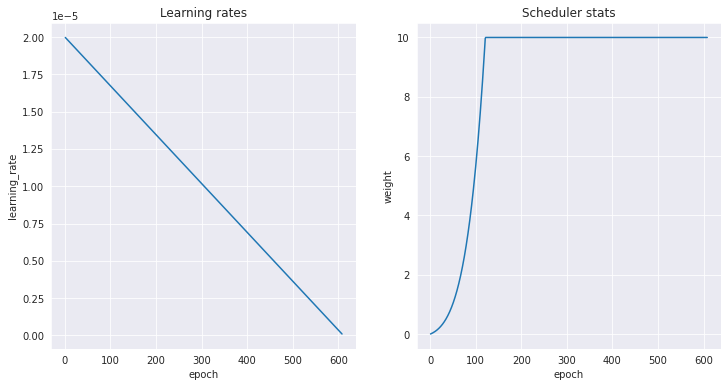

In [ ]:
if RETRAIN:
    plot_scheduler_stats({'lr_history': trainer.lr_scheduler.lr_history, 'weights_history': trainer.lr_scheduler.weight_history})

In [ ]:
# TRAIN_CONFIG = { # 0.4565|0.4598|0.4591|0.4581 -> 0.4535
#     'epochs': 5,
#     'fp16': True,
#     'gradient_accumulation_steps': 1,
#     'max_grad_norm': 1000, 
#     'batch_size': 16,
#     'apex': True,
#     # optimizer
#     'lr': 2e-5,
#     'min_lr': 1e-6,
#     'weight_decay': 0.01,
#     'encoder_lr': 2e-5,
#     'decoder_lr': 2e-5,
#     'eps': 1e-6,
#     # scheduler
#     'T_0': 500,
#     'T_max': 500,
#     'num_cycles': 0.5,
#     'num_warmup_steps': 0,
#     # kfold:
#     'n_splits': 4,
#     # freezing
#     'freeze': True,
#     'unfreeze_after': 0.6,
#     'layer_to_unfreeze': 0,
#     # reinit
#     'reinit': True,
#     'reinit_n': 1,
#     # layerwise lr
#     'layerwise_lr': 1e-5,
#     'layerwise_weight_decay': 0.01, 
#     'layerwise_lr_decay': 0.9,
#     'model': {
#         'pooling': 'mean', # weightedlayer
#         'init_weight': 'orthogonal', # xavier_uniform, xavier_normal, kaiming_uniform, kaiming_normal, orthogonal
#         'layer_start': 9,
#         'gradient_checkpointing': True,
#         'multi_sample_dropout': True,
#         'dropouts_n': 2,
#     }
# }

# -> 0.4539
# TRAIN_CONFIG = {
#     'epochs': 5,
#     'fp16': True,
#     'gradient_accumulation_steps': 1,
#     'max_grad_norm': 1000, 
#     'batch_size': 16,
#     'apex': True,
#     # optimizer
#     'lr': 2e-5,
#     'min_lr': 1e-6,
#     'weight_decay': 0.01,
#     'encoder_lr': 2e-5,
#     'decoder_lr': 2e-5,
#     'eps': 1e-6,
#     # scheduler
#     'T_0': 500,
#     'T_max': 500,
#     'num_cycles': 0.5,
#     'num_warmup_steps': 0,
#     # kfold:
#     'n_splits': 4,
#     # freezing
#     'freeze': True,
#     'unfreeze_after': 0.6,
#     'layer_to_unfreeze': 0,
#     # reinit
#     'reinit': True,
#     'reinit_n': 1,
#     # layerwise lr
#     'layerwise_lr': 1e-5,
#     'layerwise_weight_decay': 0.01, 
#     'layerwise_lr_decay': 0.9,
#     'model': {
#         'pooling': 'weightedlayer', # weightedlayer
#         'init_weight': 'xavier_normal', # xavier_uniform, xavier_normal, kaiming_uniform, kaiming_normal, orthogonal
#         'layer_start': 11,
#         'gradient_checkpointing': True,
#         'multi_sample_dropout': True,
#         'dropouts_n': 2,
#     }
# }

# TRAIN_CONFIG = { # 45.9|45.82|45.77 -> 0.4545
#     'epochs': 5,
#     'fp16': True,
#     'gradient_accumulation_steps': 1,
#     'max_grad_norm': 1000, 
#     'batch_size': 16,
#     'apex': True,
#     # optimizer
#     'lr': 2e-5,
#     'min_lr': 1e-6,
#     'weight_decay': 0.01,
#     'encoder_lr': 2e-5,
#     'decoder_lr': 2e-5,
#     'eps': 1e-6,
#     # scheduler
#     'T_0': 500,
#     'T_max': 500,
#     'num_cycles': 0.5,
#     'num_warmup_steps': 0,
#     # kfold:
#     'n_splits': 4,
#     # freezing
#     'freeze': True,
#     'unfreeze_after': 0.6,
#     'layer_to_unfreeze': 0,
#     # reinit
#     'reinit': True,
#     'reinit_n': 1,
#     # layerwise lr
#     'layerwise_lr': 1e-5,
#     'layerwise_weight_decay': 0.01, 
#     'layerwise_lr_decay': 0.9,
#     'model': {
#         'pooling': 'mean', # weightedlayer
#         'init_weight': 'normal', # orthogonal
#         'layer_start': 9,
#         'gradient_checkpointing': True,
#         'multi_sample_dropout': True,
#         'dropouts_n': 2,
#     }
# }

In [ ]:
TRAIN_CONFIG = { # 0.4565|0.4598|0.4591|0.4581 -> 0.4535
    'epochs': 5,
    'fp16': True,
    'gradient_accumulation_steps': 1,
    'max_grad_norm': 1000, 
    'batch_size': 16,
    'apex': True,
    # optimizer
    'lr': 2e-5,
    'min_lr': 1e-6,
    'weight_decay': 0.01,
    'encoder_lr': 2e-5,
    'decoder_lr': 2e-5,
    'eps': 1e-6,
    # scheduler
    'T_0': 500,
    'T_max': 500,
    'num_cycles': 0.5,
    'num_warmup_steps': 0,
    # kfold:
    'n_splits': 4,
    # freezing
    'freeze': True,
    'unfreeze_after': 0.6,
    'layer_to_unfreeze': 0,
    # reinit
    'reinit': True,
    'reinit_n': 1,
    # layerwise lr
    'layerwise_lr': 1e-5,
    'layerwise_weight_decay': 0.01, 
    'layerwise_lr_decay': 0.9,
    'model': {
        'pooling': 'mean', # weightedlayer
        'init_weight': 'orthogonal', # xavier_uniform, xavier_normal, kaiming_uniform, kaiming_normal, orthogonal
        'layer_start': 9,
        'gradient_checkpointing': True,
        'multi_sample_dropout': True,
        'dropouts_n': 2,
    }
}

In [ ]:
# ssl_model_path = mlm_model_path
# ssl_model_path = f'{BASIC_PATH}/models/ssl/{MODEL_NAME}/{TASK}/final'
# ssl_model_path = None

In [ ]:
RETRAIN = True

Training model

======================================== Fold: 1 ========================================


loading configuration file gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/configs/microsoft/deberta-v3-base/sup/config.json
Model config DebertaV2Config {
  "_name_or_path": "gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/configs/microsoft/deberta-v3-base/sup",
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": tr

Copying weights from -------> <class 'transformers.models.deberta_v2.modeling_deberta_v2.DebertaV2ForSequenceClassification'>
Copying weights to -------> <class '__main__.FeedbackModel'>
Freezing the model...
Freezing layer: base.embeddings.word_embeddings.weight
Freezing layer: base.encoder.layer.0.attention.self.query_proj.weight
Freezing layer: base.encoder.layer.0.attention.self.query_proj.bias
Freezing layer: base.encoder.layer.0.attention.self.key_proj.weight
Freezing layer: base.encoder.layer.0.attention.self.key_proj.bias
Freezing layer: base.encoder.layer.0.attention.self.value_proj.weight
Freezing layer: base.encoder.layer.0.attention.self.value_proj.bias
Freezing layer: base.encoder.layer.0.attention.output.dense.weight
Freezing layer: base.encoder.layer.0.attention.output.dense.bias
Freezing layer: base.encoder.layer.0.attention.output.LayerNorm.weight
Freezing layer: base.encoder.layer.0.attention.output.LayerNorm.bias
Freezing layer: base.encoder.layer.0.intermediate.dens

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.225 | Val Loss:  0.116 | Val MCRMSE:  0.477


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.108 | Val Loss:  0.106 | Val MCRMSE:  0.456


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 3 | Train Loss:  0.100 | Val Loss:  0.106 | Val MCRMSE:  0.456
Unfreezing the model...
Unfreezing layer: base.encoder.layer.0.attention.self.query_proj.weight
Unfreezing layer: base.encoder.layer.0.attention.self.query_proj.bias
Unfreezing layer: base.encoder.layer.0.attention.self.key_proj.weight
Unfreezing layer: base.encoder.layer.0.attention.self.key_proj.bias
Unfreezing layer: base.encoder.layer.0.attention.self.value_proj.weight
Unfreezing layer: base.encoder.layer.0.attention.self.value_proj.bias
Unfreezing layer: base.encoder.layer.0.attention.output.dense.weight
Unfreezing layer: base.encoder.layer.0.attention.output.dense.bias
Unfreezing layer: base.encoder.layer.0.attention.output.LayerNorm.weight
Unfreezing layer: base.encoder.layer.0.attention.output.LayerNorm.bias
Unfreezing layer: base.encoder.layer.0.intermediate.dense.weight
Unfreezing layer: base.encoder.layer.0.intermediate.dense.bias
Unfreezing layer: base.encoder.layer.0.output.dense.weight
Unfreezing layer:

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 4 | Train Loss:  0.097 | Val Loss:  0.105 | Val MCRMSE:  0.454
Unfreezing the model...
Unfreezing layer: base.embeddings.word_embeddings.weight


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 5 | Train Loss:  0.094 | Val Loss:  0.102 | Val MCRMSE:  0.448


  0%|          | 0/1 [00:00<?, ?it/s]

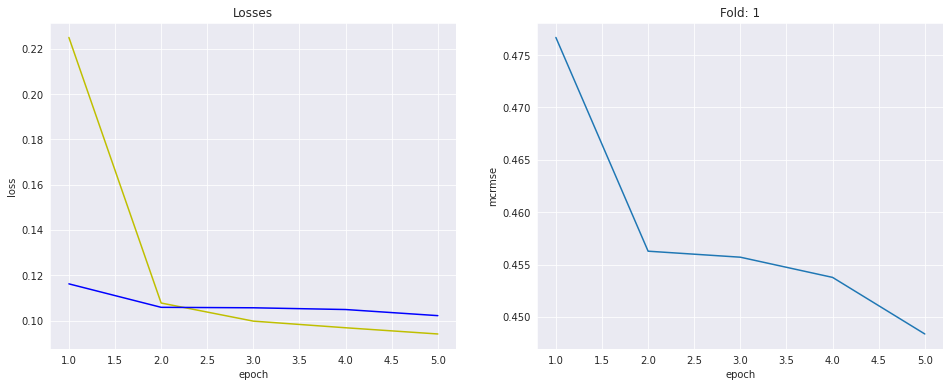

Saving model...


loading configuration file gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/configs/microsoft/deberta-v3-base/sup/config.json
Model config DebertaV2Config {
  "_name_or_path": "gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/configs/microsoft/deberta-v3-base/sup",
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": tr

Initial GPU Usage
GPU memory occupied: 6976 MB.
GPU Usage after emptying the cache
GPU memory occupied: 2504 MB.

======================================== Fold: 2 ========================================


loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-v3-base/snapshots/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/pytorch_model.bin
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model fro

Copying weights from -------> <class 'transformers.models.deberta_v2.modeling_deberta_v2.DebertaV2ForSequenceClassification'>
Copying weights to -------> <class '__main__.FeedbackModel'>
Freezing the model...
Freezing layer: base.embeddings.word_embeddings.weight
Freezing layer: base.encoder.layer.0.attention.self.query_proj.weight
Freezing layer: base.encoder.layer.0.attention.self.query_proj.bias
Freezing layer: base.encoder.layer.0.attention.self.key_proj.weight
Freezing layer: base.encoder.layer.0.attention.self.key_proj.bias
Freezing layer: base.encoder.layer.0.attention.self.value_proj.weight
Freezing layer: base.encoder.layer.0.attention.self.value_proj.bias
Freezing layer: base.encoder.layer.0.attention.output.dense.weight
Freezing layer: base.encoder.layer.0.attention.output.dense.bias
Freezing layer: base.encoder.layer.0.attention.output.LayerNorm.weight
Freezing layer: base.encoder.layer.0.attention.output.LayerNorm.bias
Freezing layer: base.encoder.layer.0.intermediate.dens

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.260 | Val Loss:  0.112 | Val MCRMSE:  0.468


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.107 | Val Loss:  0.113 | Val MCRMSE:  0.473


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 3 | Train Loss:  0.102 | Val Loss:  0.109 | Val MCRMSE:  0.461
Unfreezing the model...
Unfreezing layer: base.encoder.layer.0.attention.self.query_proj.weight
Unfreezing layer: base.encoder.layer.0.attention.self.query_proj.bias
Unfreezing layer: base.encoder.layer.0.attention.self.key_proj.weight
Unfreezing layer: base.encoder.layer.0.attention.self.key_proj.bias
Unfreezing layer: base.encoder.layer.0.attention.self.value_proj.weight
Unfreezing layer: base.encoder.layer.0.attention.self.value_proj.bias
Unfreezing layer: base.encoder.layer.0.attention.output.dense.weight
Unfreezing layer: base.encoder.layer.0.attention.output.dense.bias
Unfreezing layer: base.encoder.layer.0.attention.output.LayerNorm.weight
Unfreezing layer: base.encoder.layer.0.attention.output.LayerNorm.bias
Unfreezing layer: base.encoder.layer.0.intermediate.dense.weight
Unfreezing layer: base.encoder.layer.0.intermediate.dense.bias
Unfreezing layer: base.encoder.layer.0.output.dense.weight
Unfreezing layer:

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 4 | Train Loss:  0.097 | Val Loss:  0.106 | Val MCRMSE:  0.456
Unfreezing the model...
Unfreezing layer: base.embeddings.word_embeddings.weight


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 5 | Train Loss:  0.094 | Val Loss:  0.105 | Val MCRMSE:  0.454


  0%|          | 0/1 [00:00<?, ?it/s]

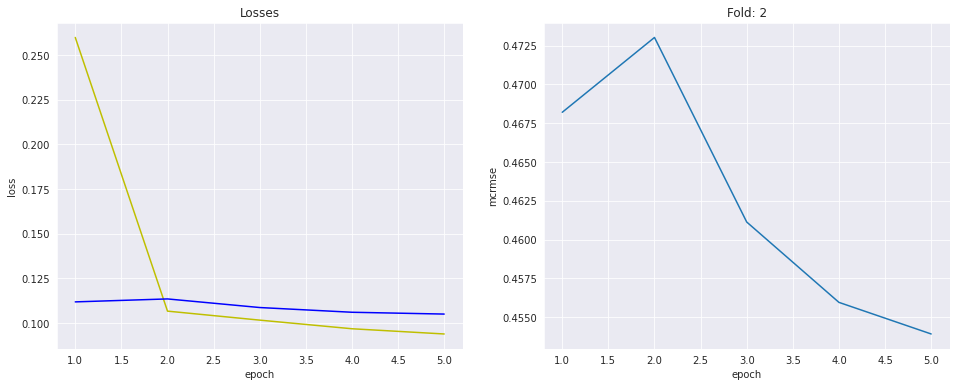

Saving model...


loading configuration file gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/configs/microsoft/deberta-v3-base/sup/config.json
Model config DebertaV2Config {
  "_name_or_path": "gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/configs/microsoft/deberta-v3-base/sup",
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": tr

Initial GPU Usage
GPU memory occupied: 6976 MB.
GPU Usage after emptying the cache
GPU memory occupied: 2504 MB.

======================================== Fold: 3 ========================================


loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-v3-base/snapshots/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/pytorch_model.bin
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model fro

Copying weights from -------> <class 'transformers.models.deberta_v2.modeling_deberta_v2.DebertaV2ForSequenceClassification'>
Copying weights to -------> <class '__main__.FeedbackModel'>
Freezing the model...
Freezing layer: base.embeddings.word_embeddings.weight
Freezing layer: base.encoder.layer.0.attention.self.query_proj.weight
Freezing layer: base.encoder.layer.0.attention.self.query_proj.bias
Freezing layer: base.encoder.layer.0.attention.self.key_proj.weight
Freezing layer: base.encoder.layer.0.attention.self.key_proj.bias
Freezing layer: base.encoder.layer.0.attention.self.value_proj.weight
Freezing layer: base.encoder.layer.0.attention.self.value_proj.bias
Freezing layer: base.encoder.layer.0.attention.output.dense.weight
Freezing layer: base.encoder.layer.0.attention.output.dense.bias
Freezing layer: base.encoder.layer.0.attention.output.LayerNorm.weight
Freezing layer: base.encoder.layer.0.attention.output.LayerNorm.bias
Freezing layer: base.encoder.layer.0.intermediate.dens

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.221 | Val Loss:  0.112 | Val MCRMSE:  0.470


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.108 | Val Loss:  0.110 | Val MCRMSE:  0.464


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 3 | Train Loss:  0.101 | Val Loss:  0.106 | Val MCRMSE:  0.456
Unfreezing the model...
Unfreezing layer: base.encoder.layer.0.attention.self.query_proj.weight
Unfreezing layer: base.encoder.layer.0.attention.self.query_proj.bias
Unfreezing layer: base.encoder.layer.0.attention.self.key_proj.weight
Unfreezing layer: base.encoder.layer.0.attention.self.key_proj.bias
Unfreezing layer: base.encoder.layer.0.attention.self.value_proj.weight
Unfreezing layer: base.encoder.layer.0.attention.self.value_proj.bias
Unfreezing layer: base.encoder.layer.0.attention.output.dense.weight
Unfreezing layer: base.encoder.layer.0.attention.output.dense.bias
Unfreezing layer: base.encoder.layer.0.attention.output.LayerNorm.weight
Unfreezing layer: base.encoder.layer.0.attention.output.LayerNorm.bias
Unfreezing layer: base.encoder.layer.0.intermediate.dense.weight
Unfreezing layer: base.encoder.layer.0.intermediate.dense.bias
Unfreezing layer: base.encoder.layer.0.output.dense.weight
Unfreezing layer:

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 4 | Train Loss:  0.098 | Val Loss:  0.103 | Val MCRMSE:  0.451
Unfreezing the model...
Unfreezing layer: base.embeddings.word_embeddings.weight


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 5 | Train Loss:  0.095 | Val Loss:  0.103 | Val MCRMSE:  0.451


  0%|          | 0/1 [00:00<?, ?it/s]

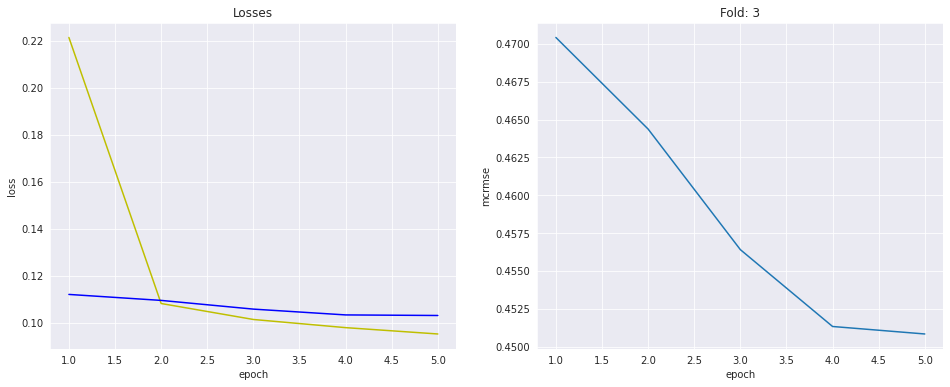

Saving model...


loading configuration file gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/configs/microsoft/deberta-v3-base/sup/config.json
Model config DebertaV2Config {
  "_name_or_path": "gdrive/MyDrive/Kaggle/feedback-prize-english-language-learning/configs/microsoft/deberta-v3-base/sup",
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": tr

Initial GPU Usage
GPU memory occupied: 6976 MB.
GPU Usage after emptying the cache
GPU memory occupied: 2504 MB.

======================================== Fold: 4 ========================================


loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-v3-base/snapshots/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/pytorch_model.bin
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model fro

Copying weights from -------> <class 'transformers.models.deberta_v2.modeling_deberta_v2.DebertaV2ForSequenceClassification'>
Copying weights to -------> <class '__main__.FeedbackModel'>
Freezing the model...
Freezing layer: base.embeddings.word_embeddings.weight
Freezing layer: base.encoder.layer.0.attention.self.query_proj.weight
Freezing layer: base.encoder.layer.0.attention.self.query_proj.bias
Freezing layer: base.encoder.layer.0.attention.self.key_proj.weight
Freezing layer: base.encoder.layer.0.attention.self.key_proj.bias
Freezing layer: base.encoder.layer.0.attention.self.value_proj.weight
Freezing layer: base.encoder.layer.0.attention.self.value_proj.bias
Freezing layer: base.encoder.layer.0.attention.output.dense.weight
Freezing layer: base.encoder.layer.0.attention.output.dense.bias
Freezing layer: base.encoder.layer.0.attention.output.LayerNorm.weight
Freezing layer: base.encoder.layer.0.attention.output.LayerNorm.bias
Freezing layer: base.encoder.layer.0.intermediate.dens

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 1 | Train Loss:  0.259 | Val Loss:  0.114 | Val MCRMSE:  0.474


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 2 | Train Loss:  0.106 | Val Loss:  0.107 | Val MCRMSE:  0.459


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 3 | Train Loss:  0.100 | Val Loss:  0.107 | Val MCRMSE:  0.459
Unfreezing the model...
Unfreezing layer: base.encoder.layer.0.attention.self.query_proj.weight
Unfreezing layer: base.encoder.layer.0.attention.self.query_proj.bias
Unfreezing layer: base.encoder.layer.0.attention.self.key_proj.weight
Unfreezing layer: base.encoder.layer.0.attention.self.key_proj.bias
Unfreezing layer: base.encoder.layer.0.attention.self.value_proj.weight
Unfreezing layer: base.encoder.layer.0.attention.self.value_proj.bias
Unfreezing layer: base.encoder.layer.0.attention.output.dense.weight
Unfreezing layer: base.encoder.layer.0.attention.output.dense.bias
Unfreezing layer: base.encoder.layer.0.attention.output.LayerNorm.weight
Unfreezing layer: base.encoder.layer.0.attention.output.LayerNorm.bias
Unfreezing layer: base.encoder.layer.0.intermediate.dense.weight
Unfreezing layer: base.encoder.layer.0.intermediate.dense.bias
Unfreezing layer: base.encoder.layer.0.output.dense.weight
Unfreezing layer:

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 4 | Train Loss:  0.096 | Val Loss:  0.106 | Val MCRMSE:  0.456
Unfreezing the model...
Unfreezing layer: base.embeddings.word_embeddings.weight


  0%|          | 0/184 [00:00<?, ?it/s]

In [ ]:
if RETRAIN:
    print('Training model')

    Path(f'{BASIC_PATH}/models/{MODEL_NAME}').mkdir(parents=True, exist_ok=True)

    kfold_results, kfold_preds, kfold_features = kfold_train_features(train_split.reset_index(drop=True), test_split, config=TRAIN_CONFIG, plot=True, save_folds=True, pretrained=ssl_model_path)
    
    with open(f'{BASIC_PATH}/models/{MODEL_NAME}/trained', 'w') as f:
        f.write(str(datetime.now()))

In [ ]:
gc.collect()
free_gpu_cache()

Initial GPU Usage
GPU memory occupied: 3324 MB.
GPU Usage after emptying the cache
GPU memory occupied: 3324 MB.


In [ ]:
predictions = kfold_preds
predictions, predictions.shape

(array([[2.910996 , 2.7542994, 3.123621 , 2.9826803, 2.7313352, 2.688611 ],
        [2.7434835, 2.493282 , 2.7014253, 2.385972 , 2.1377563, 2.5387206],
        [3.5594492, 3.3848715, 3.5440354, 3.5558984, 3.3471317, 3.2813153]],
       dtype=float32), (3, 6))

In [ ]:
submission = pd.DataFrame(predictions, columns=TARGET_VARIABLES)
submission['text_id'] = test_split['text_id'].reset_index(drop=True)
submission

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,text_id
0,2.910996,2.754299,3.123621,2.982680,2.731335,2.688611,0000C359D63E
1,2.743484,2.493282,2.701425,2.385972,2.137756,2.538721,000BAD50D026
2,3.559449,3.384871,3.544035,3.555898,3.347132,3.281315,00367BB2546B


In [ ]:
submission.to_csv(f'{BASIC_PATH}/output/submission.csv', index=False)